In [1]:
"""
Run exploration with high resolution within the connection strengths (100x100), but with only two different values for
the frequencies of the fast and slow oscillators.

"""

import numpy as np
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.models.multimodel import MultiModel
from hopf_cfc_network import SlowFastHopfNetwork
from cfcUtils import modulation_index_general, mean_vector_length, phase_locking_value, mutual_information
from scipy.signal import find_peaks
import neurolib.utils.pypetUtils as pu
import neurolib.optimize.exploration.explorationUtils as eu
import matplotlib.pyplot as plt
import h5py

import neurolib_funcs.optimize.exploration.newExplorationUtils as neu
import neurolib_funcs.optimize.exploration.testing_ExplorationUtils as teu

%load_ext autoreload
%autoreload 2

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

model = MultiModel(
    SlowFastHopfNetwork(
        number_of_slow_fast_units=1,
        slow_to_fast_connection=0.0,
        fast_to_slow_connection=0.0,
    )
)

model.params["duration"] = DURATION
model.params["sampling_dt"] = DT
model.params["dt"] = 0.01  # ms - lower dt for numba backend
# numba backend is the way to go in exploration - much faster
model.params["backend"] = "numba"

# manually add params you want to change during exploration, btw model.params is just a dictionary, so you can add whatever :)
model.params["slow_to_fast"] = 0.0
model.params["fast_to_slow"] = 0.0
model.params["bifurcation_param_slow"] = 0.25
model.params["bifurcation_param_fast"] = 0.25
model.params["frequency_slow"] = 0.04
model.params["frequency_fast"] = 0.2

In [3]:
parameters = ParameterSpace(
    {
        "slow_to_fast": np.linspace(0.0, 2., 15),
        "fast_to_slow": np.linspace(0.0, 2., 15),
        "frequency_slow": np.array([0.02, 0.04, 0.08]),
        "frequency_fast": np.array([0.15, 0.25, 0.35]),
        "bifurcation_param_slow": np.array([0.25, 0.6, 1.3, 4, 8]),
        "bifurcation_param_fast": np.array([0.25, 0.4, 0.6, 1, 4]),
    },
    allow_star_notation=True,
    kind="grid",
)

# Default params:
# slow_frequency: 0.04
# fast_frequency: 0.2
# bifurcation param: 0.25

In [4]:
def evaluateSimulation(traj):
    # get model with parameters for this run
    model = search.getModelFromTraj(traj)
    # extract stuff you want
    s_f_conn = model.params["slow_to_fast"]
    f_s_conn = model.params["fast_to_slow"]

    model.params["*connectivity"] = np.array([[0.0, f_s_conn], [s_f_conn, 0.0]])
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.a'] = model.params["bifurcation_param_slow"]
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.a'] = model.params["bifurcation_param_fast"]
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.w'] = model.params["frequency_slow"]
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.w'] = model.params["frequency_fast"]

    model.run()

    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=60, spectrum_windowsize=1)
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=60, spectrum_windowsize=1)

    peaks_fast, _ = find_peaks(pow_fast, height=max(1e-3, 1.0 * np.std(pow_fast)))
    peaks_slow, _ = find_peaks(pow_slow, height=max(1e-3, 0.5 * np.std(pow_slow)))

    if (np.allclose(np.asarray(model.x.T[100000:150000, 0]), np.asarray(model.x.T[150000:, 0]), rtol=1e-3) and
            (np.allclose(np.asarray(model.x.T[100000:150000, 1]), np.asarray(model.x.T[150000:, 1]), rtol=1e-3))):

        # that is, if in the last 10 seconds of the simulation are in a constant value, then we
        # are in a fixed point, there's no oscillation --> we're not interested
        mi = np.nan
        mvl = np.nan
        plv = np.nan
        minfo = np.nan
        p_value_mi = np.nan
        p_value_mvl = np.nan
        p_value_plv = np.nan
        p_value_minfo = np.nan

    else:
        phase_slow = np.arctan2(model.y[0, :], model.x[0, :])
        phase_fast = np.arctan2(model.y[1, :], model.x[1, :])
        amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)

        mi,_ = modulation_index_general(amp_fast, phase_slow, n_bins = 18)
        mvl,_ = mean_vector_length(amp_fast, phase_slow)
        plv,_ = phase_locking_value(phase_fast, phase_slow)
        minfo,_ = mutual_information(phase_fast, phase_slow, bins=16, log2=False)

        arg_mi = {"amplitude_fast":amp_fast}
        arg_mvl = {"amplitude_fast":amp_fast}
        arg_plv = {"phase_fast":phase_fast}
        arg_minfo = {"phase_fast":phase_fast, "bins":16, "log2":False}

        p_value_mi = compute_p_value(x_slow= model.x[0, :],y_slow=model.y[0, :],t=model.t,
                                     measured=mi,func=modulation_index_general,n=500,**arg_mi)
        p_value_mvl = compute_p_value(x_slow=model.x[0, :], y_slow=model.y[0, :], t=model.t,
                                     measured=mvl, func=mean_vector_length, n=500,**arg_mvl)
        p_value_plv = compute_p_value(x_slow=model.x[0, :], y_slow=model.y[0, :], t=model.t,
                                     measured=plv, func=phase_locking_value, n=500,**arg_plv)
        p_value_minfo = compute_p_value(x_slow=model.x[0, :], y_slow=model.y[0, :], t=model.t,
                                     measured=minfo, func=mutual_information, n=500,**arg_minfo)



    result_dict = {
        "peaks_freq_fast": peaks_fast,
        "peaks_freq_slow": peaks_slow,
        "modulation_index": mi,
        "mean_vector_length_abs": mvl,
        "phase_locking_value_abs": plv,
        "mutual_information": minfo,
        "p_value_mi": p_value_mi,
        "p_value_mvl": p_value_mvl,
        "p_value_plv": p_value_plv,
        "p_value_minfo": p_value_minfo

    }


    search.saveToPypet(result_dict, traj)


In [5]:
search = BoxSearch(
    model=model,
    evalFunction=evaluateSimulation,
    parameterSpace=parameters,
    filename="medium_resolution_exploration_p_values.hdf",
    ncores=5,
)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/medium_resolution_exploration_p_values.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 50625
MainProcess root INFO     BoxSearch: Environment initialized.


In [6]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/medium_resolution_exploration_p_values.hdf
MainProcess root INFO     Analyzing trajectory results-2022-05-31-19H-02M-21S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/medium_resolution_exploration_p_values.hdf`.
MainProcess pypet.storageservice.HDF5StorageService WARNING  Current pypet version is 0.6.0 with python 3.8.10 but your trajectory was created with version 0.6.0 under python 3.9.7. Yet, you enforced the load, so I will handle the trajectory despite the version mismatch.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-05-31-19H-02M-21S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mod

In [7]:
search.dfResults

,slow_to_fast,fast_to_slow,frequency_slow,frequency_fast,bifurcation_param_slow,bifurcation_param_fast,phase_locking_value_abs,peaks_freq_slow,peaks_freq_fast,p_value_plv,p_value_mvl,p_value_minfo,p_value_mi,mutual_information,modulation_index,mean_vector_length_abs
0,0.0,0.0,0.02,0.15,0.25,0.25,0.000446,[3],[24],1.0,0.332,0.074,0.180,0.014322,4.534741e-10,0.002187
1,0.0,0.0,0.02,0.15,0.25,0.40,0.000446,[3],[24],1.0,0.328,0.070,0.238,0.014333,1.776262e-09,0.002769
2,0.0,0.0,0.02,0.15,0.25,0.60,0.000446,[3],[24],1.0,0.324,0.072,0.270,0.014321,2.166023e-09,0.003393
3,0.0,0.0,0.02,0.15,0.25,1.00,0.000446,[3],[24],1.0,0.318,0.084,0.270,0.014257,1.889365e-09,0.004379
4,0.0,0.0,0.02,0.15,0.25,4.00,0.000446,[3],[24],1.0,0.316,0.076,0.298,0.014302,5.971211e-10,0.008747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50620,2.0,2.0,0.08,0.35,8.00,0.25,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
50621,2.0,2.0,0.08,0.35,8.00,0.40,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
50622,2.0,2.0,0.08,0.35,8.00,0.60,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
50623,2.0,2.0,0.08,0.35,8.00,1.00,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def try_division(row, exceptVal):
    try:
        return row["slow_to_fast"]/row["fast_to_slow"]
    except ZeroDivisionError:
        return np.inf
search.dfResults["ratio_freq"]=search.dfResults.apply(
    lambda row: row["frequency_fast"]/row["frequency_slow"],axis=1)

search.dfResults["ratio_conn"]=search.dfResults.apply(
    lambda row: try_division(row,0),axis=1)

In [9]:
search.dfResults

,slow_to_fast,fast_to_slow,frequency_slow,frequency_fast,bifurcation_param_slow,bifurcation_param_fast,phase_locking_value_abs,peaks_freq_slow,peaks_freq_fast,p_value_plv,p_value_mvl,p_value_minfo,p_value_mi,mutual_information,modulation_index,mean_vector_length_abs,ratio_freq,ratio_conn
0,0.0,0.0,0.02,0.15,0.25,0.25,0.000446,[3],[24],1.0,0.332,0.074,0.180,0.014322,4.534741e-10,0.002187,7.500,inf
1,0.0,0.0,0.02,0.15,0.25,0.40,0.000446,[3],[24],1.0,0.328,0.070,0.238,0.014333,1.776262e-09,0.002769,7.500,inf
2,0.0,0.0,0.02,0.15,0.25,0.60,0.000446,[3],[24],1.0,0.324,0.072,0.270,0.014321,2.166023e-09,0.003393,7.500,inf
3,0.0,0.0,0.02,0.15,0.25,1.00,0.000446,[3],[24],1.0,0.318,0.084,0.270,0.014257,1.889365e-09,0.004379,7.500,inf
4,0.0,0.0,0.02,0.15,0.25,4.00,0.000446,[3],[24],1.0,0.316,0.076,0.298,0.014302,5.971211e-10,0.008747,7.500,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50620,2.0,2.0,0.08,0.35,8.00,0.25,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375,1.0
50621,2.0,2.0,0.08,0.35,8.00,0.40,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375,1.0
50622,2.0,2.0,0.08,0.35,8.00,0.60,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375,1.0
50623,2.0,2.0,0.08,0.35,8.00,1.00,NaN,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375,1.0


MainProcess root INFO     Saving to ./data/figures/mi_medium_exploration.png


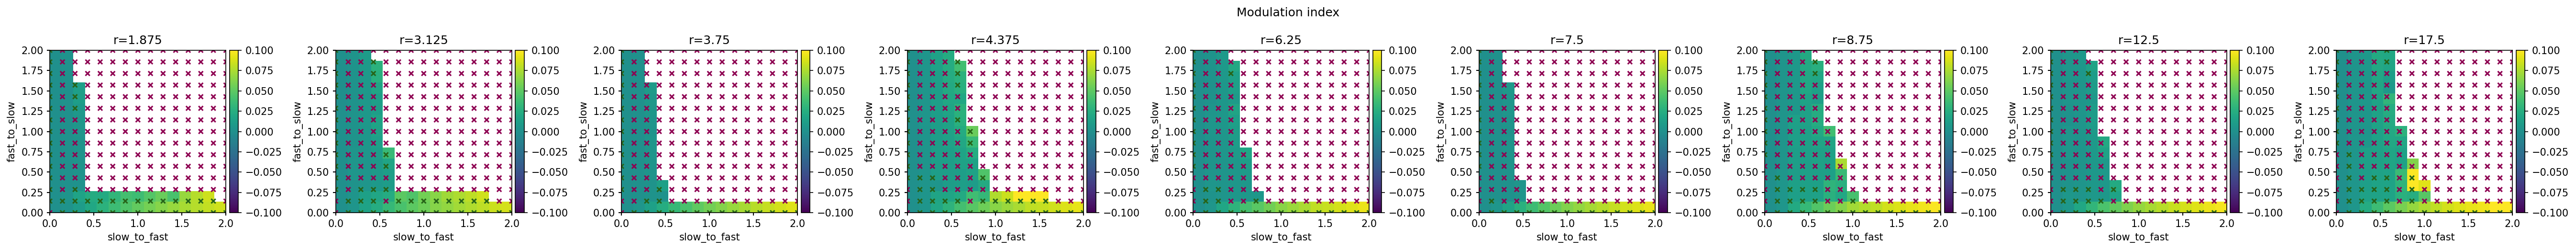

In [16]:
# eu.plotExplorationResults(
#     search.dfResults,
#     par1=["slow_to_fast", r"slow_to_fast"],
#     par2=["fast_to_slow", r"fast_to_slow"],
#     plot_key="p_value_mi",
#     nan_to_zero=True,
#     by= "ratio_freq",
#     one_figure= True,
#     plot_key_label="P value Modulation index",
#     savename = "p_values_mi_medium_exploration.png"
# )
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="modulation_index",
    nan_to_zero=True,
    by="ratio_freq",
    one_figure=True,
    plot_key_label="Modulation index",
    p_vals=True,
    p_vals_label="p_value_mi",
    savename = "mi_medium_exploration.png"
)

MainProcess root INFO     Saving to ./data/figures/mvl_medium_exploration.png


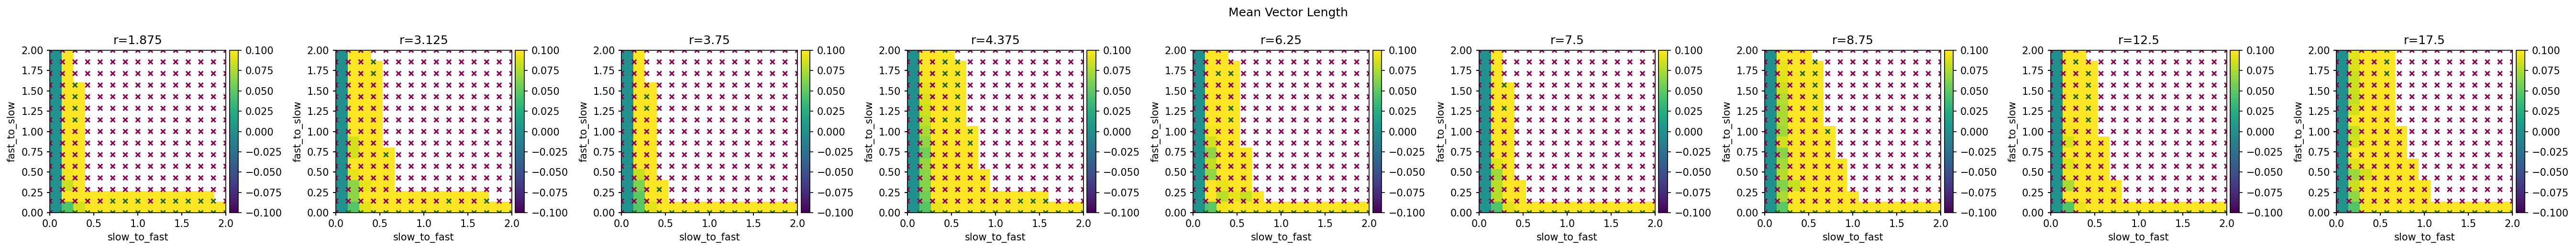

In [17]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="mean_vector_length_abs",
    nan_to_zero=True,
    by="ratio_freq",
    one_figure=True,
    plot_key_label="Mean Vector Length",
    p_vals=True,
    p_vals_label="p_value_mvl",
    savename = "mvl_medium_exploration.png"
)

MainProcess root INFO     Saving to ./data/figures/minfo_medium_exploration.png


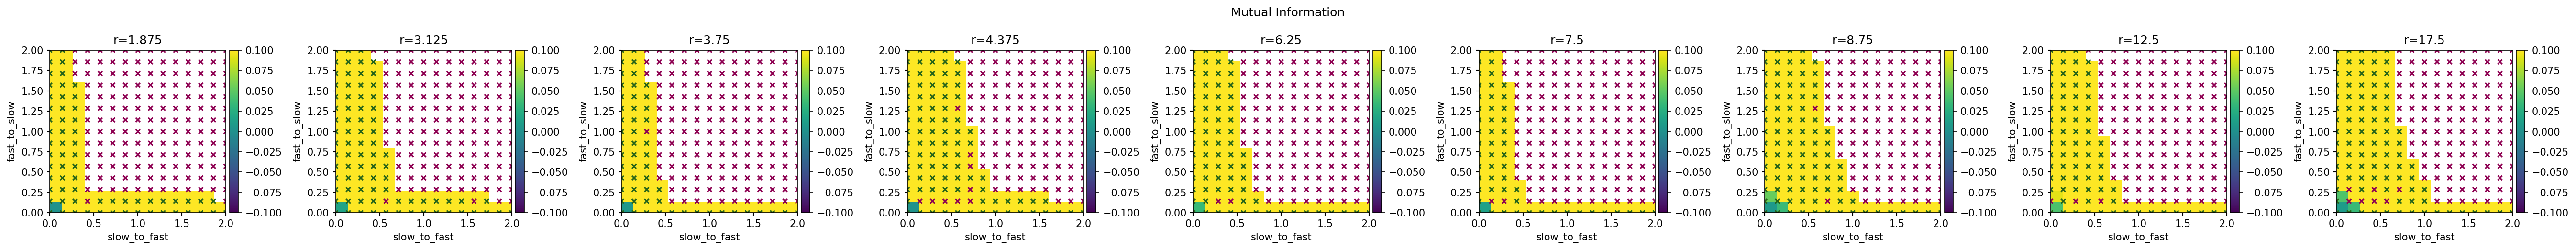

In [18]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="mutual_information",
    nan_to_zero=True,
    by="ratio_freq",
    one_figure=True,
    plot_key_label="Mutual Information",
    p_vals=True,
    p_vals_label="p_value_minfo",
    savename = "minfo_medium_exploration.png"
)

MainProcess root INFO     Saving to ./data/figures/plv_medium_exploration.png


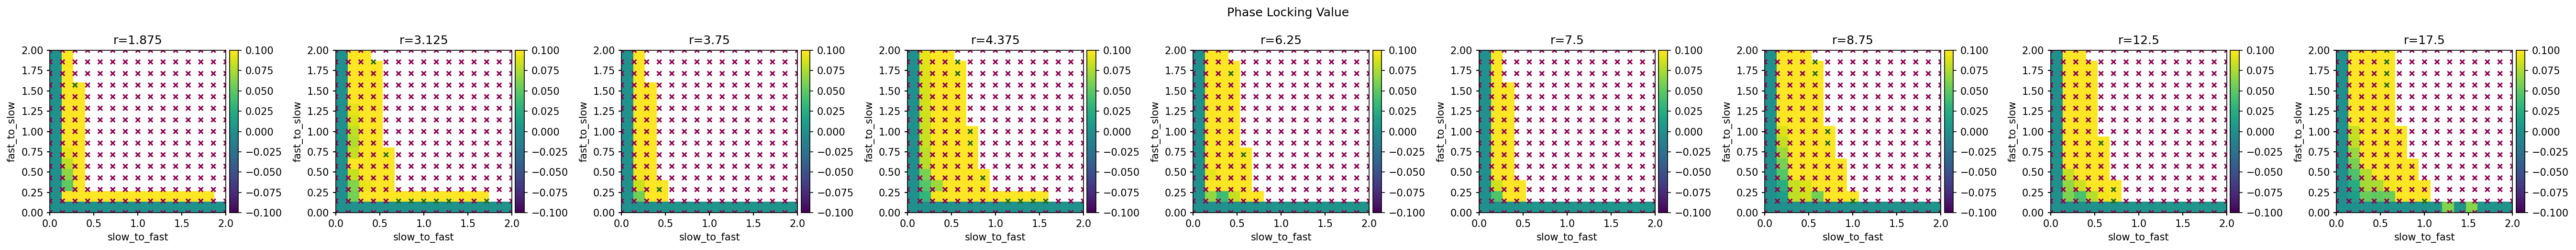

In [19]:
teu.plotExplorationResults(
    search.dfResults,
    par1=["slow_to_fast", r"slow_to_fast"],
    par2=["fast_to_slow", r"fast_to_slow"],
    plot_key="phase_locking_value_abs",
    nan_to_zero=True,
    by="ratio_freq",
    one_figure=True,
    plot_key_label="Phase Locking Value",
    p_vals=True,
    p_vals_label="p_value_plv",
    savename = "plv_medium_exploration.png"
)

In [20]:
df_pivot = search.dfResults.pivot_table(values="p_value_plv", index="bifurcation_param_fast", columns="bifurcation_param_slow",aggfunc=np.nanmean)

In [21]:
np.unique(search.dfResults["bifurcation_param_slow"])

array([0.25, 0.6 , 1.3 , 4.  , 8.  ])

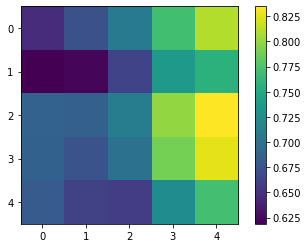

In [22]:
plt.imshow(df_pivot)
plt.colorbar()

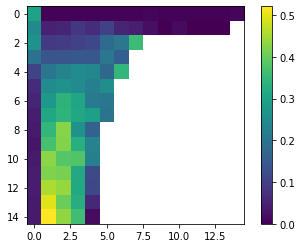

In [23]:
df_pivot_pvalmi = search.dfResults.pivot_table(values="p_value_mi", index="fast_to_slow", columns="slow_to_fast",aggfunc=np.nanmean)
#df_pivot_pvalmi.fillna(-np.inf)
plt.imshow(df_pivot_pvalmi)
plt.colorbar()


In [24]:
df_pivot_pvalmi
df_pivot_pvalmi = df_pivot_pvalmi.fillna(-np.inf)
df_pivot_pvalmi

slow_to_fast,0.000000,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.000000,1.142857,1.285714,1.428571,1.571429,1.714286,1.857143,2.000000
fast_to_slow,,,,,,,,,,,,,,,
0.000000,0.302711,0.005244,0.005369,0.005191,0.005156,0.005173,0.004622,0.005440,0.006427,0.005404,0.005467,0.005796,0.006089,0.005947,0.006107
0.142857,0.246622,0.048206,0.054302,0.084968,0.067179,0.102622,0.053750,0.044556,0.022000,0.000000,0.015500,0.002000,0.000000,0.000000,-inf
0.285714,0.264560,0.088979,0.092721,0.101519,0.110909,0.181200,0.205833,0.358000,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0.428571,0.195618,0.137915,0.139072,0.142649,0.144190,0.206000,0.155111,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0.571429,0.103849,0.204706,0.233603,0.252139,0.242649,0.175667,0.344667,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0.714286,0.063440,0.250443,0.265508,0.251652,0.222625,0.257455,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
0.857143,0.053031,0.278226,0.335860,0.307938,0.213680,0.203750,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1.000000,0.040036,0.309636,0.339618,0.312129,0.293909,0.198000,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1.142857,0.038018,0.345430,0.425927,0.267492,0.163263,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


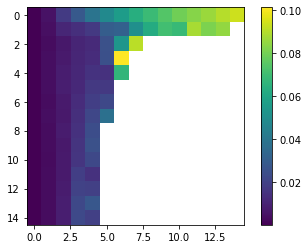

In [25]:
df_pivot_mi = search.dfResults.pivot_table(values="modulation_index", index="fast_to_slow", columns="slow_to_fast",aggfunc=np.nanmean)
df_pivot_mi.fillna(-np.inf)
plt.imshow(df_pivot_mi)
plt.colorbar()

In [27]:
df_sig_pvalmi = df_pivot_pvalmi[(df_pivot_pvalmi<0.1) & (df_pivot_pvalmi>-1)]
df_sig_pvalmi = df_sig_pvalmi.fillna(0)

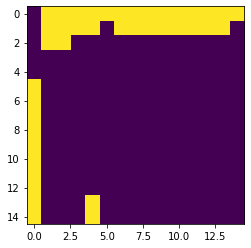

In [28]:
plt.imshow(np.array((df_pivot_pvalmi<0.1) & (df_pivot_pvalmi>-1)).astype(int))